In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.9.0
numpy 1.26.4
pandas 2.2.2
sklearn 1.5.0
torch 2.3.1+cpu
cpu


# 准备数据

In [2]:
from tensorflow import keras
#用karas有的数据集imdb，电影分类,分电影是积极的，还是消极的
imdb = keras.datasets.imdb
#载入数据使用下面两个参数
vocab_size = 10000  #词典大小，仅保留训练数据中前10000个最经常出现的单词，低频单词被舍弃
index_from = 3  #0,1,2,3空出来做别的事
#前一万个词出现词频最高的会保留下来进行处理，后面的作为特殊字符处理，
# 小于3的id都是特殊字符，下面代码有写
# 需要注意的一点是取出来的词表还是从1开始的，需要做处理
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words = vocab_size, index_from = index_from)

In [3]:
print("train", train_data.shape, train_labels.shape)
print("test", test_data.shape, test_labels.shape)

train (25000,) (25000,)
test (25000,) (25000,)


In [4]:
#载入词表，看下词表长度，词表就像英语字典
word_index = imdb.get_word_index()
print(len(word_index))
print(type(word_index))
#词表虽然有8万多，但是我们只载入了最高频的1万词！！！！

88584
<class 'dict'>


## 构造 word2idx 和 idx2word

In [5]:
word2idx = {word: idx + 3 for word, idx in word_index.items()}
word2idx.update({
    "[PAD]": 0,     # 填充 token
    "[BOS]": 1,     # begin of sentence
    "[UNK]": 2,     # 未知 token
    "[EOS]": 3,     # end of sentence
})

idx2word = {idx: word for word, idx in word2idx.items()}

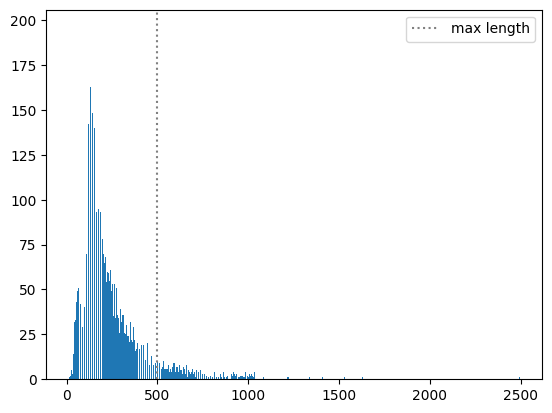

In [6]:
# 选择 max_length
length_collect = {}
for text in train_data:
    length = len(text)
    length_collect[length] = length_collect.get(length, 0) + 1
    
MAX_LENGTH = 500
plt.bar(length_collect.keys(), length_collect.values())
plt.axvline(MAX_LENGTH, label="max length", c="gray", ls=":")
plt.legend()
plt.show()

## Tokenizer

In [7]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx
    
    def encode(self, text_list, padding_first=False):
        """如果padding_first == True，则padding加载前面，否则加载后面"""
        max_length = min(self.max_length, 2 + max([len(text) for text in text_list]))
        indices_list = []
        for text in text_list:
            indices = [self.bos_idx] + [self.word2idx.get(word, self.unk_idx) for word in text[:max_length-2]] + [self.eos_idx] #直接切片取前max_length-2个单词，然后加上bos和eos
            if padding_first:
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:
                indices = indices + [self.pad_idx] * (max_length - len(indices))
            indices_list.append(indices)
        return torch.tensor(indices_list)
    
    
    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break
                text.append(word)
            text_list.append(" ".join(text) if not split else text)
        return text_list
    

tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices = tokenizer.encode(raw_text, padding_first=True)
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)
print("raw text")
for raw in raw_text:
    print(raw)
print("indices")
for index in indices:
    print(index)
print("decode text")
for decode in decode_text:
    print(decode)

raw text
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
indices
tensor([   0,    0,    0,    1, 4825,  182,    3])
tensor([    1,     2,  3004,     2,    19, 19233,     3])
tensor([   0,    1,   14,    9,    6, 2181,    3])
decode text
[PAD] [PAD] [PAD] [BOS] hello world [EOS]
[BOS] [UNK] text [UNK] with batch [EOS]
[PAD] [BOS] this is a test [EOS]


In [8]:
# 看看训练集的数据

tokenizer.decode(train_data[:2], remove_bos=False, remove_eos=False, remove_pad=False)

["[BOS] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UNK] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [UNK] to the two little boy's that played the [UNK] of norman and paul they were just brilliant children are often left out of the [UNK] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

## 数据集与 DataLoader

In [9]:
from torch.utils.data import Dataset, DataLoader

class IMDBDataset(Dataset):
    def __init__(self, data, labels, remain_length=True):
        if remain_length:
            self.data = tokenizer.decode(data, remove_bos=False, remove_eos=False, remove_pad=False)
        else:
            # 缩减一下数据
            self.data = tokenizer.decode(data)
        self.labels = labels
    
    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]
        return text, label
    
    def __len__(self):
        return len(self.data)
    
    
def collate_fct(batch):
    text_list = [item[0].split() for item in batch]
    label_list = [item[1] for item in batch]
    # 这里使用 padding first
    text_list = tokenizer.encode(text_list, padding_first=True).to(dtype=torch.int)
    return text_list, torch.tensor(label_list).reshape(-1, 1).to(dtype=torch.float)


# 用RNN，缩短序列长度
train_ds = IMDBDataset(train_data, train_labels, remain_length=False)
test_ds = IMDBDataset(test_data, test_labels, remain_length=False)

In [10]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fct)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fct)

In [11]:
for text, label in train_dl:
    print(text.shape, label.shape)
    break

torch.Size([128, 500]) torch.Size([128, 1])


# 定义模型

In [47]:
class RNN(nn.Module):
    def __init__(self, embedding_dim=16, hidden_dim=64, vocab_size=vocab_size, num_layers=1, bidirectional=False):
        super(RNN, self).__init__()
        self.embeding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.layer = nn.Linear(hidden_dim * (2 if bidirectional else 1), hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # [bs, seq length]
        x = self.embeding(x)
        # [bs, seq length, embedding_dim] -> shape [bs, embedding_dim, seq length]
        seq_output, final_hidden = self.rnn(x)
        # [bs, seq length, hidden_dim], [*, bs, hidden_dim]
        x = seq_output[:, -1, :]
        # 取最后一个时间步的输出 (这也是为什么要设置padding_first=True的原因)
        x = self.layer(x)
        x = self.fc(x)
        return x
    
sample_inputs = torch.randint(0, vocab_size, (2, 128))
    
print("{:=^80}".format(" 一层单向 RNN "))       
for key, value in RNN().named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

    
print("{:=^80}".format(" 一层双向 RNN "))       
for key, value in RNN(bidirectional=True).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

    
print("{:=^80}".format(" 俩层单向 RNN "))       
for key, value in RNN(num_layers=2).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")


=================================== 一层单向 RNN ===================================
            embeding.weight             paramerters num: 160000
            rnn.weight_ih_l0            paramerters num: 1024
            rnn.weight_hh_l0            paramerters num: 4096
             rnn.bias_ih_l0             paramerters num: 64
             rnn.bias_hh_l0             paramerters num: 64
              layer.weight              paramerters num: 4096
               layer.bias               paramerters num: 64
               fc.weight                paramerters num: 64
                fc.bias                 paramerters num: 1
=================================== 一层双向 RNN ===================================
            embeding.weight             paramerters num: 160000
            rnn.weight_ih_l0            paramerters num: 1024
            rnn.weight_hh_l0            paramerters num: 4096
             rnn.bias_ih_l0             paramerters num: 64
             rnn.bias_hh_l0             p

# 训练

In [48]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        # 二分类
        preds = logits > 0
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [49]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [50]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [51]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [52]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits > 0
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 20

# model = RNN(bidirectional=True)
# model = RNN(num_layers=2)
model = RNN(bidirectional=True,num_layers=2)
# 1. 定义损失函数 采用交叉熵损失 (但是二分类)
loss_fct = F.binary_cross_entropy_with_logits
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/imdb-rnn")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/imdb-rnn", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10)

model = model.to(device)
record = training(
    model, 
    train_dl, 
    test_dl, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
    )

  0%|          | 0/3920 [00:00<?, ?it/s]

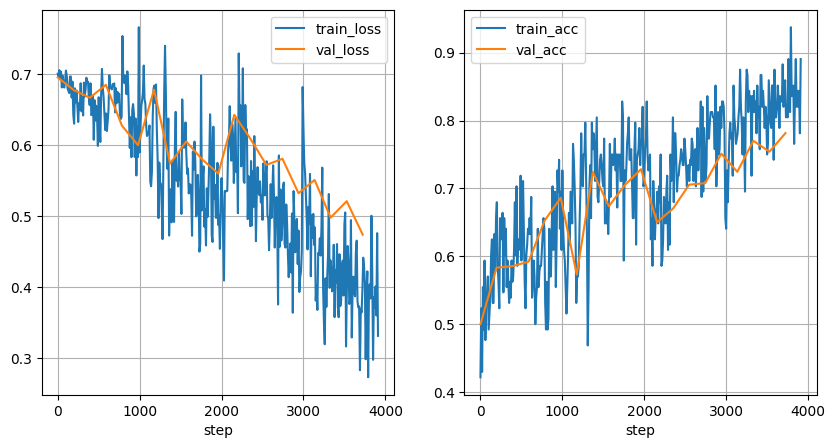

In [53]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=10)  #横坐标是 steps

# 评估

In [54]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/imdb-rnn/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.4738
accuracy: 0.7816
